2024-04-23 15:55:22.066 Python[59404:2526497] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Custom Canny Edge Pixels: 10314
OpenCV Canny Edge Pixels: 3575


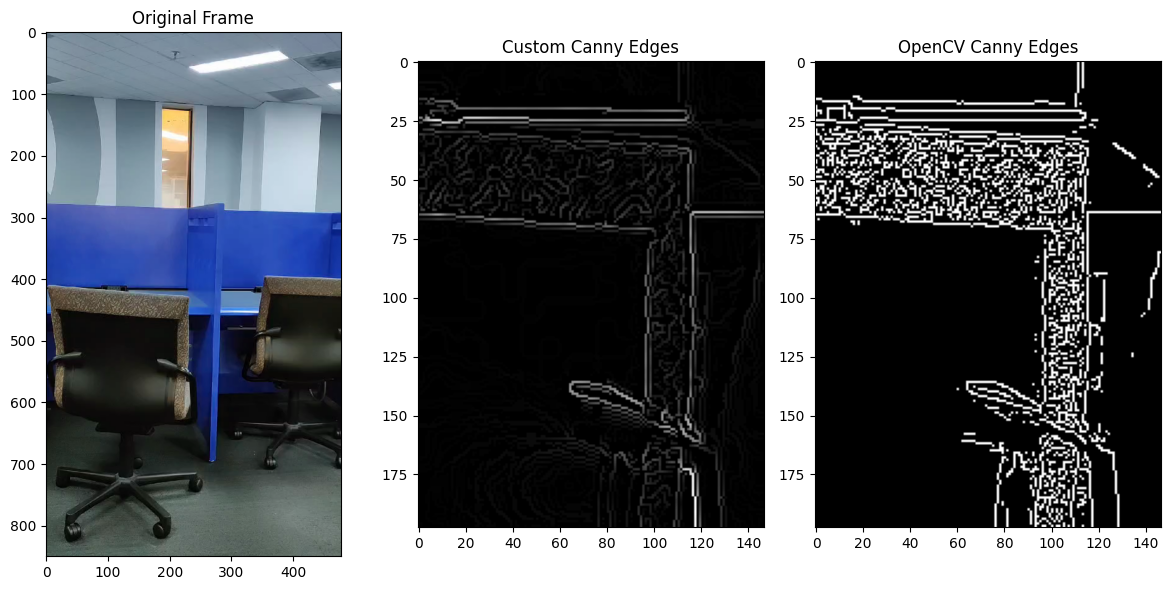

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

def canny_edge_detector(img, weak_th=None, strong_th=None):

    # Noise reduction step
    img = cv2.GaussianBlur(img, (5, 5), 1.4)

    # Calculating the gradients
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)

    # Conversion of Cartesian coordinates to polar
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees=True)

    # setting the minimum and maximum thresholds for double thresholding
    mag_max = np.max(mag)
    if not weak_th:
        weak_th = mag_max * 0.005
    if not strong_th:
        strong_th = mag_max * 2

    # getting the dimensions of the input image
    height, width = img.shape

    # Looping through every pixel of the grayscale image
    for i_x in range(width):
        for i_y in range(height):

            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang - 180) if abs(grad_ang) > 180 else abs(grad_ang)

            # selecting the neighbours of the target pixel according to the gradient direction
            # In the x axis direction
            if grad_ang <= 22.5:
                neighb_1_x, neighb_1_y = i_x - 1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

            # top right (diagonal-1) direction
            elif grad_ang > 22.5 and grad_ang <= (22.5 + 45):
                neighb_1_x, neighb_1_y = i_x - 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1

            # In y-axis direction
            elif grad_ang > (22.5 + 45) and grad_ang <= (22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y - 1
                neighb_2_x, neighb_2_y = i_x, i_y + 1

            # top left (diagonal-2) direction
            elif grad_ang > (22.5 + 90) and grad_ang <= (22.5 + 135):
                neighb_1_x, neighb_1_y = i_x - 1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y - 1

            # Now it restarts the cycle
            elif grad_ang > (22.5 + 135) and grad_ang <= (22.5 + 180):
                neighb_1_x, neighb_1_y = i_x - 1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

            # Non-maximum suppression step
            if width > neighb_1_x >= 0 and height > neighb_1_y >= 0:
                if mag[i_y, i_x] < mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x] = 0
                    continue

            if width > neighb_2_x >= 0 and height > neighb_2_y >= 0:
                if mag[i_y, i_x] < mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x] = 0

    weak_ids = np.zeros_like(img)
    strong_ids = np.zeros_like(img)
    ids = np.zeros_like(img)

    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):
            grad_mag = mag[i_y, i_x]

            if grad_mag < weak_th:
                mag[i_y, i_x] = 0
            elif grad_mag >= strong_th:
                ids[i_y, i_x] = 2
            else:
                ids[i_y, i_x] = 1

    # gradients of edges
    return mag

# Load the video
video_path = "static/SampleVideo.mp4"
cap = cv2.VideoCapture(video_path)

# Read the first frame from the video
ret, frame = cap.read()

# Convert frame to grayscale for OpenCV's Canny function
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Select ROI
roi = cv2.selectROI(gray_frame)
cv2.destroyAllWindows()

# Check if ROI selection is valid
if roi[2] == 0 or roi[3] == 0:
    print("Invalid ROI selection. Please try again.")
    exit()

# Extract a 5x5 patch from the selected ROI
patch_size = 5
patch_x, patch_y, patch_width, patch_height = roi
patch = gray_frame[patch_y:patch_y + patch_height, patch_x:patch_x + patch_width]

# Check if patch is empty
if patch.size == 0:
    print("Selected ROI does not contain any image data.")
    exit()

# Define threshold1 (adjust based on image characteristics)
threshold1 = 0.2 * gray_frame.max()
threshold2 = 1 * threshold1

# Apply OpenCV's built-in Canny edge detection
opencv_canny = cv2.Canny(patch, threshold1, threshold2)

# Apply your custom Canny edge detection function
custom_canny = canny_edge_detector(patch.copy())

# Compare edge pixels (consider using a metric like Intersection over Union (IoU))
custom_edge_pixels = np.count_nonzero(custom_canny)
opencv_edge_pixels = np.count_nonzero(opencv_canny)
print("Custom Canny Edge Pixels:", custom_edge_pixels)
print("OpenCV Canny Edge Pixels:", opencv_edge_pixels)

# Displaying the input image, custom Canny edges, and OpenCV Canny edges
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(frame), plt.title("Original Frame")
plt.subplot(132), plt.imshow(custom_canny, cmap="gray"), plt.title("Custom Canny Edges")
plt.subplot(133), plt.imshow(opencv_canny, cmap="gray"), plt.title("OpenCV Canny Edges")
plt.tight_layout()
plt.show()